# 1. Dependências e Constantes

In [2]:
# Import das Libs
import os

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk
import gensim
import seaborn as sns
import re


nltk.download('words')

pd.set_option('display.max_rows', 150)
from nltk.corpus import words
from textblob import TextBlob
from googletrans import Translator
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from lyrics_analysis.clean_data import tokenize_lemmatize, word_count,  normalize, detect_lang_lyrics
from lyrics_analysis.analyse_data import n_most_common
%matplotlib inline

[nltk_data] Downloading package words to
[nltk_data]     /Users/bruno.santos/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
sns.set_style("whitegrid")


In [4]:
# Constantes
DATA_RAW_NAME = 'lyrics.csv'
DATA_STOPWORDS_NAME = 'stopwords.txt'
DATA_PROCESSED_NAME = 'lyrics_processed.csv'
DATA_RAW_PATH =  os.path.abspath(os.path.join('..', 'data','raw', DATA_RAW_NAME))
DATA_STOPWORDS_PATH = os.path.abspath(os.path.join('..', 'data','raw', DATA_STOPWORDS_NAME))
DATA_PROCESSED_PATH = os.path.abspath(os.path.join('..', 'data','processed', DATA_PROCESSED_NAME ))

In [5]:
# Dados
lyrics_raw = pd.read_csv(DATA_RAW_PATH)
stopwords = pd.read_csv(DATA_STOPWORDS_PATH)
stopwords = stopwords['stopwords'].tolist()
stopwords = list(map(lambda x: x.replace(' ', ''),stopwords))
stopwords += words.words()

# 2. Limpeza Inicial

In [6]:
lyrics_raw

,group,lyrics_title,lyrics_text
0,Legião Urbana,1° de Julho,Eu vejo que aprendi O quanto te ensinei E é n...
1,Legião Urbana,1965 (Duas Tribos),Vou passar Quero ver Volta aqui Vem você Como...
2,Legião Urbana,1977,Todos os dias quando acordo de manhã Não tenh...
3,Legião Urbana,A Canção Do Senhor Da Guerra,Existe alguém esperando por você Que vai comp...
4,Legião Urbana,A Cruz e a Espada,"Havia um tempo, em que eu vivia Um sentimento..."
...,...,...,...
3424,Los Hermanos,Um Par,"Mesmo quando ele consegue o que ele quis, Qua..."
3425,Los Hermanos,Uma Brasileira,"Rodas em sol, Trovas em dó Uma brasileira, ô ..."
3426,Los Hermanos,Vai Embora,Não sei mais o que fazer da minha vida sem vo...
3427,Los Hermanos,Vambora,Entre por essa porta agora E diga que me ador...


In [7]:
# Dropando músicas iguais
#lyrics_raw.drop_duplicates(subset=['lyrics_text','lyricis_title'], inplace=True)
#print(f'sobraram {lyrics_raw.shape[0]} músicas')

sobraram 3389 músicas


In [7]:
# Dropando músicas iguais
#lyrics_raw.drop_duplicates(subset=['lyrics_title'], inplace=True)
#print(f'sobraram {lyrics_raw.shape[0]} músicas')

In [8]:
# identificando o idioma 
lyrics_raw_lang = detect_lang_lyrics(lyrics_raw, 'lyrics_text')


100%|██████████| 3429/3429 [23:13<00:00,  2.46it/s]


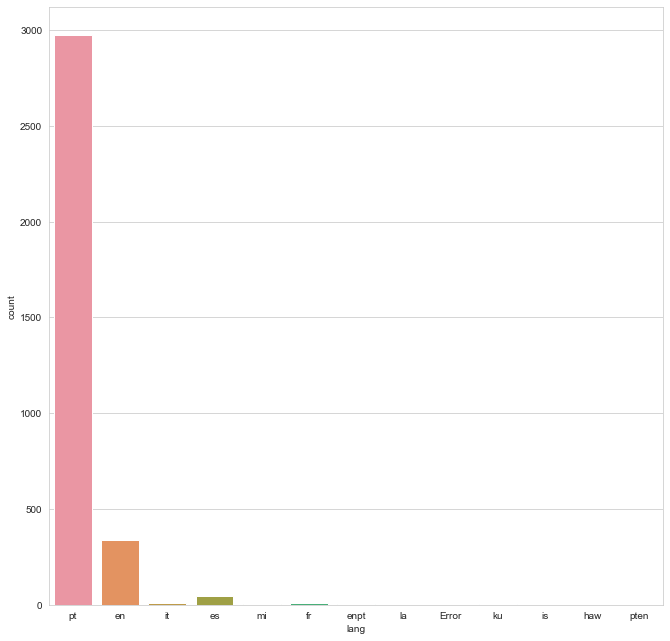

In [9]:
# QUe idiomas temos?
fig, ax = plt.subplots(figsize=(11, 11))

ax = sns.countplot(x="lang", data=lyrics_raw_lang)
plt.savefig(os.path.abspath(os.path.join(os.getcwd(),'..', 'img','lang_freq.jpg')))

In [10]:
# Removing numbers
lyrics_raw_lang['lyrics_text'] = lyrics_raw_lang['lyrics_text'].apply(lambda x: re.sub(r'\b\d+(?:\.\d+)?\s+', '', x))

In [12]:
#Lower casing
lyrics_lang_normalized = normalize(lyrics_raw_lang, 'lyrics_text', 'lyrics_text_normalized')

In [13]:
#Quantos instrumentais temos?
(lyrics_lang_normalized['lyrics_text_normalized'].str.contains('instrumental')).sum()

8

In [20]:
# Removendo os instrumentais
lyrics_lang_normalized['is_instrumental'] = lyrics_lang_normalized['lyrics_text_normalized'].str.contains('instrumental')
lyrics_lang_normalized = lyrics_lang_normalized[lyrics_lang_normalized['is_instrumental'] == False]

In [21]:
# Replace para substituir gíria usada 
lyrics_lang_normalized['lyrics_text_normalized'] = lyrics_lang_normalized['lyrics_text_normalized'].apply(lambda x: x.replace('pra', 'para'))

In [22]:
# Filtrando para remover os erros na identificação da linguagem e as músicas que são instrumentais
lyrics_lang_normalized = lyrics_lang_normalized.loc[(lyrics_lang_normalized['is_instrumental']==False) | (lyrics_lang_normalized['lang']=='Error'),:]

In [23]:
# Traduzindo as músicas de outro idioma para o português
lyrics_translated_pt= []
lyrics_translated_en = []
trl = Translator()
for lang, lyrics_text_normalized in tqdm(zip(lyrics_lang_normalized['lang'],lyrics_lang_normalized['lyrics_text_normalized'])):
    sent = lyrics_text_normalized
    try:
        lyrics_translated_pt.append(trl.translate(sent, src = lang, dest='pt').text)
    except:
        lyrics_translated_pt.append('Error')
        
    try:
        lyrics_translated_en.append(trl.translate(sent, src = lang, dest = 'en').text)
    except:
        lyrics_translated_en.append('Error')


3381it [48:05,  1.17it/s]


In [24]:
lyrics_lang_normalized['lyrics_text_normalized_en'] = lyrics_translated_en
lyrics_lang_normalized['lyrics_text_normalized_pt'] = lyrics_translated_pt

In [25]:
lyrics_lang_normalized_tokenized = tokenize_lemmatize(lyrics_lang_normalized, column = 'lyrics_text_normalized_pt', 
                                       new_name='lyrics_text_normalized_tokenized_pt', remove_stopwords=True, stopwords=stopwords)

In [26]:
lyrics_lang_normalized_tokenized.to_csv(DATA_PROCESSED_PATH, index = False)

# 3.Análise Exploratória

## 3.2 Word Cloud

In [210]:
lyrics_lang_normalized_tokenized = pd.read_csv(DATA_PROCESSED_PATH)

In [211]:
lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[(lyrics_lang_normalized_tokenized['lyrics_text_normalized_pt'] != 'Error') 
                                                          & (lyrics_lang_normalized_tokenized['lyrics_text_normalized_en'] != 'Error')]

In [212]:
lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'] = lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].str.split()

In [213]:
lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].apply(lambda x: type(x)==list)]

In [214]:
top10terms = n_most_common(lyrics_lang_normalized_tokenized, 'lyrics_text_normalized_tokenized_pt', n=10)

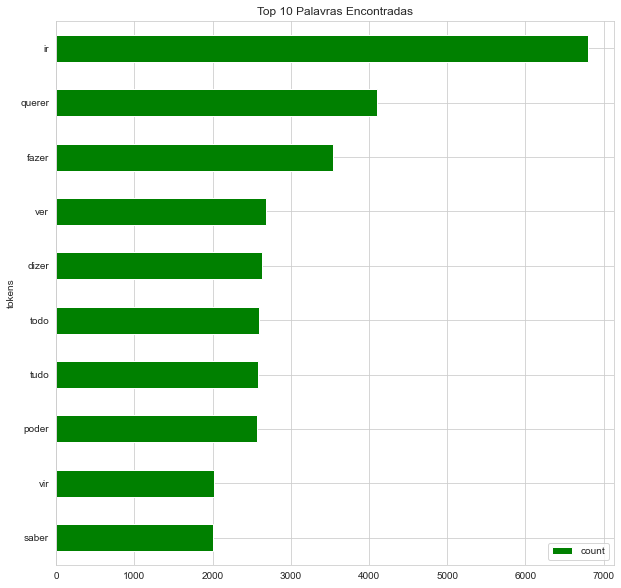

In [215]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot horizontal bar graph
top10terms.sort_values(by='count').plot.barh(x='tokens',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Top 10 Palavras Encontradas")

plt.savefig(os.path.abspath(os.path.join('..', 'img','top_10_tokens.jpg')))
plt.show()



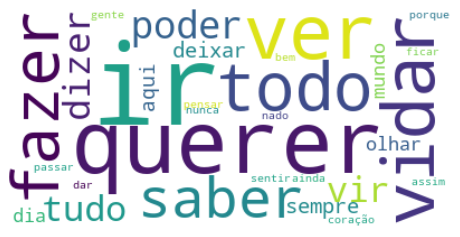

In [216]:
import itertools
all_tokens = lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].tolist()
all_tokens = list(itertools.chain(*all_tokens))
wordcloud = WordCloud(max_font_size=100, max_words=30, background_color="white").generate(' '.join(all_tokens))
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(os.path.abspath(os.path.join('..', 'img','word_cloud_50.jpg')))
plt.show()

## 3.3 Tokens per Artists

In [217]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bruno.santos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [218]:
sid = SentimentIntensityAnalyzer()

In [219]:
lyrics_lang_normalized_tokenized['count_tokens'] = lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].apply(lambda x: len(x))

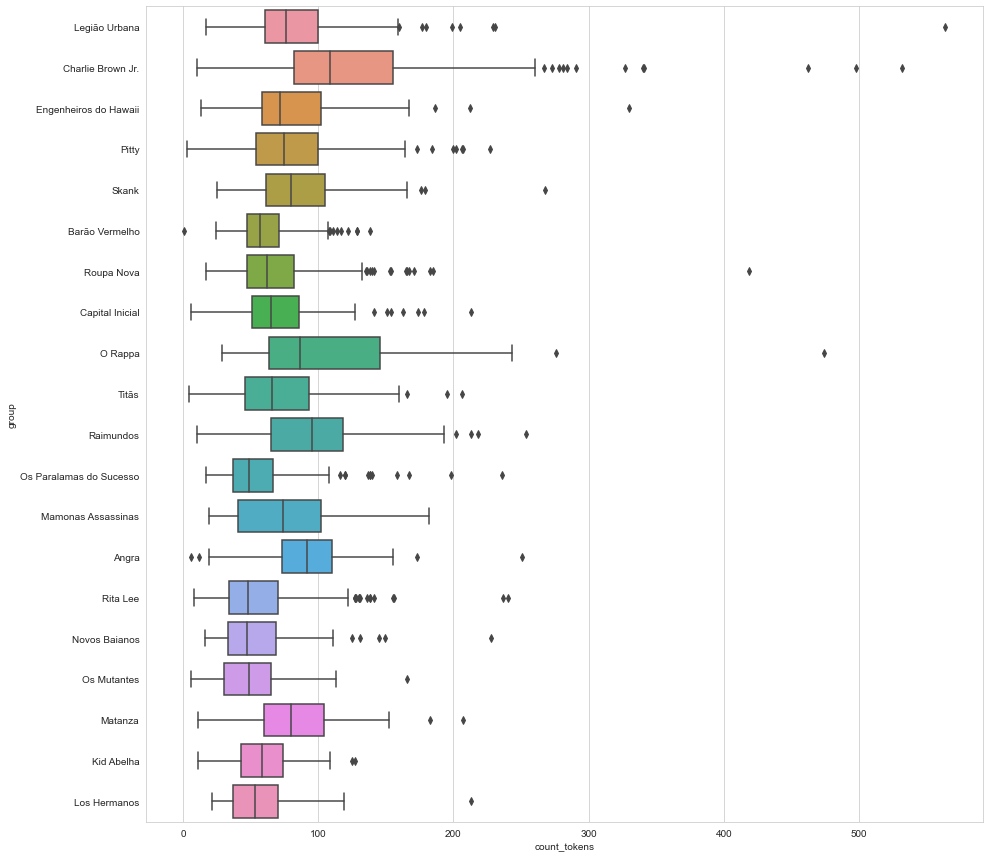

In [220]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="count_tokens", y="group", data=lyrics_lang_normalized_tokenized, orient = 'h')
plt.savefig(os.path.abspath(os.path.join(os.getcwd(),'..', 'img','tokens_per_artist.jpg')))

## 3.4 Unique Tokens Per Artists


In [221]:
list_unique_group = lyrics_lang_normalized_tokenized['group'].unique()
group_unique_tokens = {}
for group in list_unique_group:
    all_tokens = lyrics_lang_normalized_tokenized.loc[lyrics_lang_normalized_tokenized['group']==group,'lyrics_text_normalized_tokenized_pt'].tolist()
    all_tokens = list(itertools.chain(*all_tokens))
    group_unique_tokens[group] = len(set(all_tokens))
    

In [222]:
unique_tokens = pd.DataFrame.from_dict(group_unique_tokens, orient = 'index').reset_index()

In [223]:
unique_tokens.columns = ['group', 'unique_tokens']

In [ ]:
unique_tokens.sort_values(by='group',inplace=True)

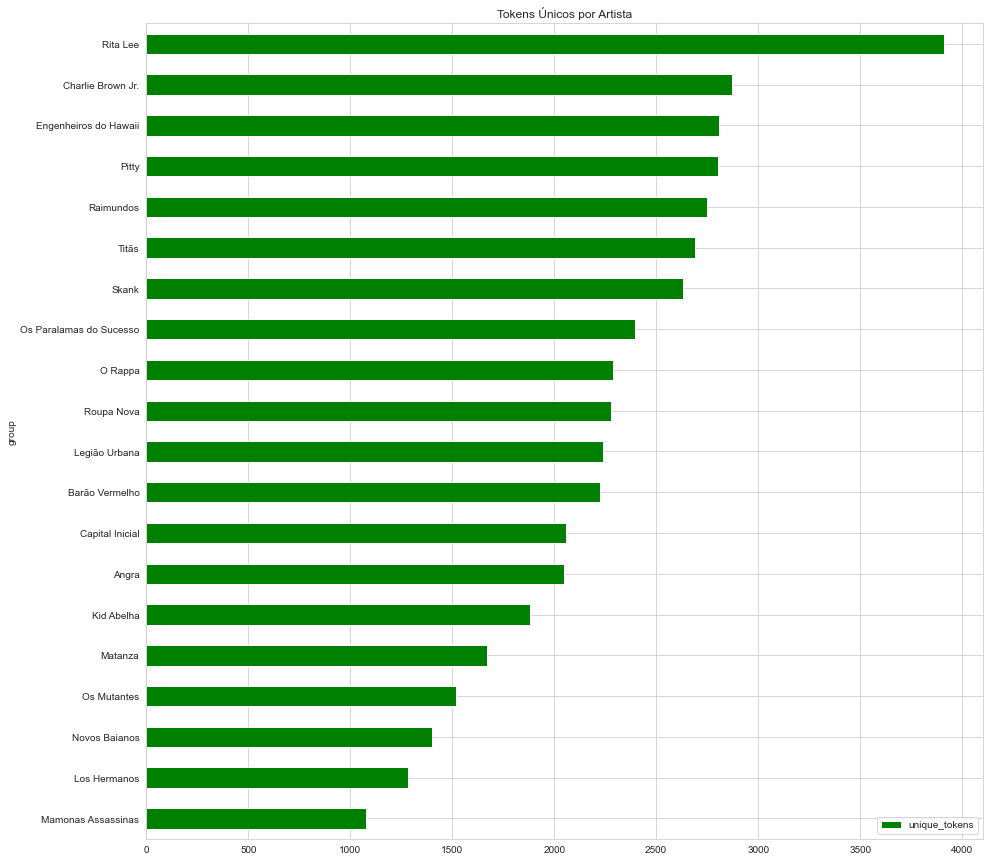

In [224]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot horizontal bar graph
unique_tokens.sort_values(by= 'unique_tokens').plot.barh(x='group',
                      y='unique_tokens',
                      ax=ax,
                      color="green")

ax.set_title("Tokens Únicos por Artista")

plt.savefig(os.path.abspath(os.path.join('..', 'img','unique_tokens_per_artist.jpg')))
plt.show()

In [377]:
unique_tokens['total_tokens'] = lyrics_lang_normalized_tokenized.groupby('group').sum()['count_tokens'].values

In [379]:
unique_tokens['vocabulary'] = unique_tokens['unique_tokens']/unique_tokens['total_tokens']

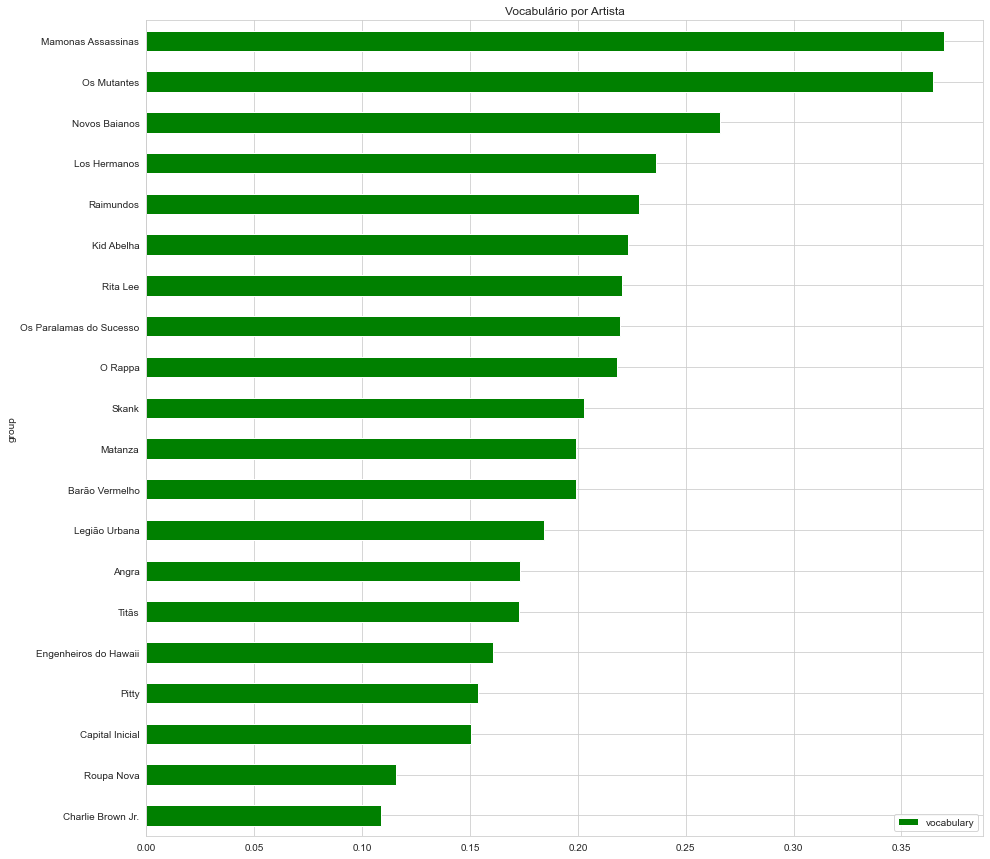

In [380]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot horizontal bar graph
unique_tokens.sort_values(by= 'vocabulary').plot.barh(x='group',
                      y='vocabulary',
                      ax=ax,
                      color="green")

ax.set_title("Vocabulário por Artista")

plt.savefig(os.path.abspath(os.path.join('..', 'img','riqueza_vocabulario_artists.jpg')))
plt.show()

## 3.4 Número de Músicas por Artista

In [225]:
group_count_lyrics = pd.DataFrame(lyrics_lang_normalized_tokenized['group'].value_counts().reset_index())
group_count_lyrics.columns = ['group', 'n_lyrics']

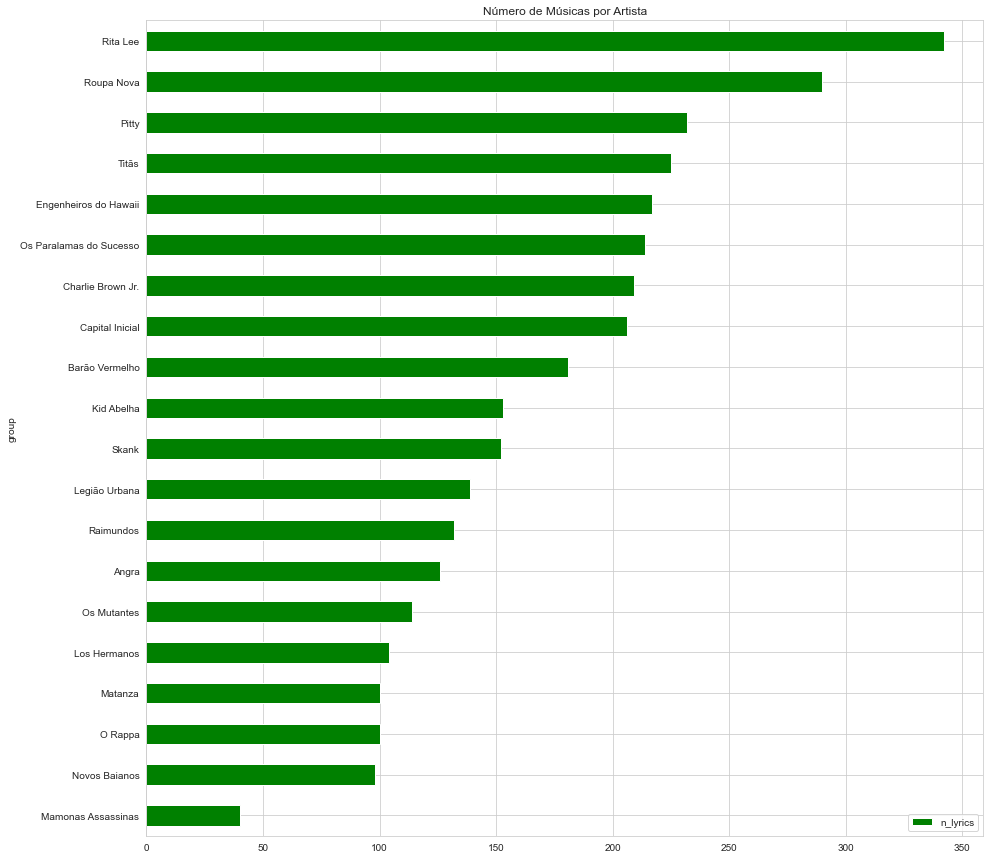

In [226]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot horizontal bar graph
group_count_lyrics.sort_values(by= 'n_lyrics').plot.barh(x='group',
                      y='n_lyrics',
                      ax=ax,
                      color="green")

ax.set_title("Número de Músicas por Artista")

plt.savefig(os.path.abspath(os.path.join('..', 'img','lyrics_per_artist.jpg')))
plt.show()



In [227]:
unique_tokens_count_lyrics = group_count_lyrics.merge(unique_tokens, on ='group', how = 'inner')

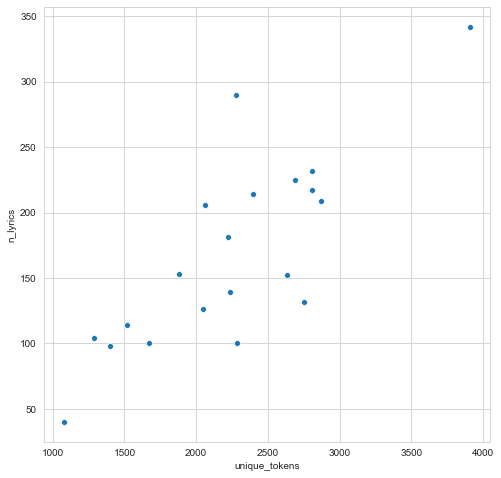

In [228]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.scatterplot(x="unique_tokens", y="n_lyrics", data=unique_tokens_count_lyrics)
plt.savefig(os.path.abspath(os.path.join('..', 'img','unique_tokens_vs_n_lyrics.jpg')))

## 3.5 Sentimento

In [229]:
sentiment_lyrics = []
for lyrics_text in tqdm(lyrics_lang_normalized_tokenized['lyrics_text_normalized_en']):
    try:
        lyrics_text_blob = TextBlob(lyrics_text)
        sentiment_lyrics.append(lyrics_text_blob.sentiment[0])
    except:
        sentiment_lyrics.append(-999)
lyrics_lang_normalized_tokenized['lyrics_sentiment'] = sentiment_lyrics
lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[lyrics_lang_normalized_tokenized['lyrics_sentiment']!=-999]

100%|██████████| 3374/3374 [00:02<00:00, 1241.11it/s]


In [230]:
sentiment_lyrics_pos = []
sentiment_lyrics_neu = []
sentiment_lyrics_neg = []

for lyrics_text in tqdm(lyrics_lang_normalized_tokenized['lyrics_text_normalized_en']):
    try:
        lyrics_text_sentiment = sid.polarity_scores(lyrics_text)
        sentiment_lyrics_pos.append(lyrics_text_sentiment['pos'])
        sentiment_lyrics_neg.append(lyrics_text_sentiment['neg'])
        sentiment_lyrics_neu.append(lyrics_text_sentiment['neu'])

    except:
        sentiment_lyrics_pos.append(-999)
        sentiment_lyrics_neg.append(-999)
        sentiment_lyrics_neu.append(-999)
lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_pos'] = sentiment_lyrics_pos
lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neg'] = sentiment_lyrics_neg
lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neu'] = sentiment_lyrics_neu

lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[(lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_pos']!=-999) & (lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neg']!=-999) & (lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neu']!=-999)]

100%|██████████| 3374/3374 [00:03<00:00, 848.40it/s] 


In [231]:
sentiment_group_vader = lyrics_lang_normalized_tokenized.groupby(['group']).agg({'lyrics_sentiment_vader_pos':'mean', 'lyrics_sentiment_vader_neg':'mean','lyrics_sentiment_vader_neu':'mean'}).sort_values(by='lyrics_sentiment_vader_pos', ascending = False)

In [232]:
sentiment_group_vader

,lyrics_sentiment_vader_pos,lyrics_sentiment_vader_neg,lyrics_sentiment_vader_neu
group,,,
Roupa Nova,0.194655,0.074031,0.731303
Charlie Brown Jr.,0.166584,0.099450,0.733986
Rita Lee,0.163570,0.100091,0.736374
Barão Vermelho,0.163337,0.112956,0.723773
Los Hermanos,0.160221,0.091183,0.748615
Kid Abelha,0.147693,0.092686,0.759654
Legião Urbana,0.145302,0.118388,0.736288
Os Mutantes,0.139675,0.074026,0.786333
Os Paralamas do Sucesso,0.138224,0.097280,0.764547


In [233]:
sentiment_group = lyrics_lang_normalized_tokenized.groupby(['group']).agg({'lyrics_sentiment':'mean'}).sort_values(by='lyrics_sentiment', ascending = False)

In [234]:
sentiment_group

,lyrics_sentiment
group,
Roupa Nova,0.211517
Los Hermanos,0.169059
Charlie Brown Jr.,0.148889
Novos Baianos,0.141222
Skank,0.140203
Kid Abelha,0.133439
Rita Lee,0.126418
Os Paralamas do Sucesso,0.119768
Os Mutantes,0.115100


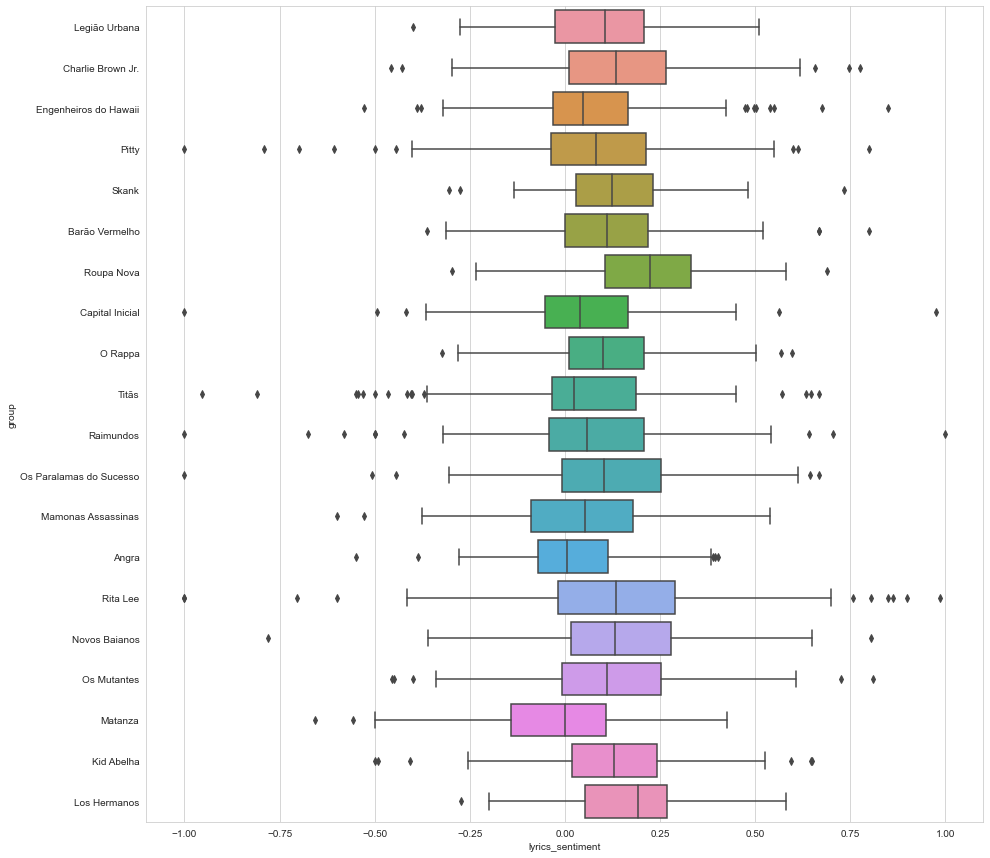

In [235]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="lyrics_sentiment", y="group", data=lyrics_lang_normalized_tokenized, orient = 'h')
plt.savefig(os.path.abspath(os.path.join('..', 'img','sentiment_artists.jpg')))

In [236]:
lyrics_lang_normalized_tokenized.drop_duplicates(subset=['lyrics_title'], inplace=True)

In [237]:
lyrics_lang_normalized_tokenized.nlargest(columns = 'lyrics_sentiment',n= 10)

,group,lyrics_title,lyrics_text,lang,lyrics_text_normalized,is_instrumental,lyrics_text_normalized_en,lyrics_text_normalized_pt,lyrics_text_normalized_tokenized_pt,count_tokens,lyrics_sentiment,lyrics_sentiment_vader_pos,lyrics_sentiment_vader_neg,lyrics_sentiment_vader_neu
1981,Raimundos,Carro Forte,"Da mulher eu faço o carro forte Dos peitos, f...",pt,"da mulher eu faço o carro forte dos peitos, f...",False,"I make the car strong for the breasts, I make ...","da mulher eu faço o carro forte dos peitos, fa...","[mulher, fazer, carro, peito, fazer, farol, pe...",79,1.000000,0.066,0.086,0.848
2530,Rita Lee,Bwana,Bwana Bwana Me chama que eu vou Sou tua mulhe...,pt,bwana bwana me chama que eu vou sou tua mulhe...,False,bwana bwana calls me that I am your robot woma...,bwana bwana me chama que eu vou sou tua mulher...,"[bwana, bwana, chamar, ir, mulher, robô, teleg...",87,0.985938,0.254,0.065,0.681
1451,Capital Inicial,Auá-Auá,"Se eu não tenho mar, nem um puto Nem alguém ...",pt,"se eu não tenho mar, nem um puto nem alguém ...",False,"if i don't have a sea, not a kid or someone to...","se eu não tenho mar, nem um puto nem alguém p...","[puto, alguém, tudo, poder, fazer, auá-auá]",6,0.976562,0.241,0.000,0.759
2678,Rita Lee,Menino Bonito,Lindo! E eu me sinto enfeitiçada Correndo per...,pt,lindo! e eu me sinto enfeitiçada correndo per...,False,pretty! and I feel bewitched in danger your lo...,lindo! e eu me sinto enfeitiçada correndo peri...,"[sentir, enfeitiçar, correr, perigar, olhar, s...",45,0.862500,0.181,0.075,0.744
478,Engenheiros do Hawaii,Nuvem Passageira,"Eu sou nuvem passageira, Que como vento se va...",pt,"eu sou nuvem passageira, que como vento se va...",False,"I am a passing cloud, like the wind goes, I am...","eu sou nuvem passageira, que como vento se vai...","[nuvem, passageiro, ventar, ir, cristal, quebr...",39,0.850000,0.161,0.054,0.785
2644,Rita Lee,It's Very Nice Pra Xuxu,Hoje tudo mudou Ontem amei você O que você me...,pt,hoje tudo mudou ontem amei você o que você me...,False,today everything changed yesterday I loved you...,hoje tudo mudou ontem amei você o que você me ...,"[hoje, tudo, mudar, ontem, amar, dar, morrer, ...",37,0.847941,0.369,0.046,0.585
2792,Rita Lee,Valsa de Uma Cidade,Vento do mar no meu rosto E um sol a queimar....,pt,vento do mar no meu rosto e um sol a queimar....,False,sea ​​wind on my face and a burning sun ... bu...,vento do mar no meu rosto e um sol a queimar.....,"[ventar, rostir, queimar, queimar, calçar, che...",31,0.804688,0.269,0.015,0.717
2865,Novos Baianos,Na cadência do samba,Batucada de bamba Cadência bonita do samba Ba...,pt,batucada de bamba cadência bonita do samba ba...,False,batucada de bamba beautiful cadence of samba b...,batucada de bamba cadência bonita do samba bat...,"[batucar, bambo, cadência, bonito, batucar, ba...",149,0.804348,0.287,0.184,0.528
794,Pitty,Você Não Sabe O Que Perdeu,Pra onde eu vou Não precisa de dinheiro Pra o...,pt,para onde eu vou não precisa de dinheiro para...,False,where i go do not need money where i go is joy...,para onde eu vou não precisa de dinheiro para ...,"[onde, ir, preciso, onde, ir, alegria, inteira...",14,0.800000,0.091,0.062,0.847
1039,Barão Vermelho,Não Há Dinheiro Que Pague,Eu sempre acreditei Que a qualquer hora Eu pu...,pt,eu sempre acreditei que a qualquer hora eu pu...,False,I always believed that anytime I could leave y...,eu sempre acreditei que a qualquer hora eu pud...,"[sempre, acreditar, qualquer, poder, deixar, p...",54,0.800000,0.067,0.252,0.681


In [238]:
print(lyrics_lang_normalized_tokenized.loc[lyrics_lang_normalized_tokenized['lyrics_title']=='Cruela Cruel', ['lyrics_text_normalized_pt']].values)

[["sou um ninho no estranho mundo perigoso, insano nexo, yogas e roquebrou nunca a vida se mostrou assim tão cruela cruel, cruela cruel sou madre de calcutá tentando salvar o planeta às vezes destruo o universo com o garbo de uma greta viúva negra de maquiavel maquiavel, maquiavel... cruela cruel, cruela cruela... it's heaven in hell os inimigos ocultos se mostram incompetentes tédio, anfa e paranóia sempre achei no amor a glória mais cruela cruel cruela cruel terra telepática lunática, anos-luz sem ídolos, heróis, profetas, gurus só a sombra de uma bomba, bruxa má medusa jezebel jezebel, jezebel... cruela cruel, cruela cruela cruela cruel, cruela cruela cruela cruel it's heaven in hell!"]]


In [239]:
lyrics_lang_normalized_tokenized.nlargest(columns = 'lyrics_sentiment_vader_neg',n= 10)

,group,lyrics_title,lyrics_text,lang,lyrics_text_normalized,is_instrumental,lyrics_text_normalized_en,lyrics_text_normalized_pt,lyrics_text_normalized_tokenized_pt,count_tokens,lyrics_sentiment,lyrics_sentiment_vader_pos,lyrics_sentiment_vader_neg,lyrics_sentiment_vader_neu
2557,Rita Lee,Cruela Cruel,"Sou um ninho no estranho Mundo perigoso, insa...",pt,"sou um ninho no estranho mundo perigoso, insa...",False,"I am a nest in the strange dangerous world, in...","sou um ninho no estranho mundo perigoso, insan...","[ninhar, estranhar, mundo, perigoso, insano, n...",69,-0.704301,0.063,0.642,0.295
1931,Titãs,Tô Cansado,Tô cansado Tô cansado de tudo Tô cansado do m...,pt,tô cansado tô cansado de tudo tô cansado do m...,False,I'm tired I'm tired of everything I'm tired of...,tô cansado tô cansado de tudo tô cansado do me...,"[tô, cansar, tô, cansar, tudo, tô, cansar, cab...",77,-0.370759,0.000,0.598,0.402
2009,Raimundos,I Don't Care,I don't care I don't care I don't care about ...,en,i don't care i don't care i don't care about ...,False,i don't care i don't care i don't care about t...,"Eu não ligo, eu não ligo, eu não ligo para est...","[Eu, ligar, ligar, ligar, mundo, ligar, garoto...",36,0.000000,0.000,0.586,0.414
1887,Titãs,Planeta Morto,Era um planeta fértil Tinha as maiores frutas...,pt,era um planeta fértil tinha as maiores frutas...,False,it was a fertile planet had the biggest fruits...,era um planeta fértil tinha as maiores frutas ...,"[fértil, maior, frutar, cheio, homem, forte, p...",71,-0.157619,0.052,0.501,0.447
3027,Matanza,Alabama Death Tenebris,Alabama grindcore Holy noise - death tenebris...,en,alabama grindcore holy noise - death tenebris...,False,alabama grindcore holy noise - death tenebris ...,Alabama Grindcore Santo barulho - morte Tenebr...,"[Grindcore, barulhar, morte, Tenebris, conspir...",29,-0.435732,0.000,0.478,0.522
149,Charlie Brown Jr.,"Ai, Ai, Ai (Estúdio Coca-cola)",Tchunanananã! Ná Nã Nã! Ná Nã Nã! Ná Nã Nã! T...,pt,tchunanananã! ná nã nã! ná nã nã! ná nã nã! t...,False,tchunanananã! no no no! no no no! no no no! tc...,tchunanananã! ná nã nã! ná nã nã! ná nã nã! tc...,"[tchunanananã, ná, nã, nã, ná, nã, nã, ná, nã,...",210,0.410623,0.088,0.459,0.453
2008,Raimundos,Hooligans,hooligans are made to destroy hooligans are b...,en,hooligans are made to destroy hooligans are b...,False,hooligans are made to destroy hooligans are bo...,hooligans são feitos para destruir hooligans n...,"[hooligan, feito, destruir, hooligan, nascer, ...",36,-0.050000,0.112,0.455,0.433
2497,Rita Lee,As Loucas,Eles amam as loucas Mas se casam com outras E...,pt,eles amam as loucas mas se casam com outras e...,False,they love the crazy but they marry others they...,eles amam as loucas mas se casam com outras el...,"[amar, louco, casar, outro, amar, louco, casar...",78,-0.288830,0.243,0.450,0.307
3075,Matanza,Matarei,Não havia aquela hora mais ninguém no bar Alé...,pt,não havia aquela hora mais ninguém no bar alé...,False,there was no one else at the bar but the waite...,não havia aquela hora mais ninguém no bar além...,"[ninguém, além, garçom, arrumar, ali, esperar,...",50,0.037500,0.000,0.445,0.555
527,Engenheiros do Hawaii,Revelação,Um dia vestido De saudade viva Faz ressucitar...,pt,um dia vestido de saudade viva faz ressucitar...,False,"one day dressed with longing, he resurrects ba...",um dia vestido de saudade viva faz ressucitar ...,"[dia, vestir, saudade, fazer, ressucitar, casa...",37,-0.183333,0.077,0.440,0.483


In [240]:
df_topics = lyrics_lang_normalized_tokenized[lyrics_lang_normalized_tokenized['lang']=='pt']

In [241]:
all_lyrics_list = list(df_topics['lyrics_text_normalized_tokenized_pt'])

In [243]:
lyrics_lang_normalized_tokenized.reset_index(drop=True,inplace=True)

## 3.6 Tópicos

### 3.6.1 LDiA

In [189]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(all_lyrics_list, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_lyrics_list], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [190]:

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [191]:
lyrics_bigrams = make_bigrams(all_lyrics_list)


In [192]:
id2word = corpora.Dictionary(lyrics_bigrams)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in lyrics_bigrams]

In [193]:
# Build LDA model
np.random.seed(32)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=500,
                                           passes=300,
                                           alpha='auto',
                                           per_word_topics=True)

In [194]:

# Visualize the topics

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.299776  0.035248       1        1  72.240921
2     -0.083287 -0.076134       2        1  11.050650
3     -0.074169 -0.162706       3        1  10.147406
0     -0.142320  0.203593       4        1   6.561014, topic_info=        Term         Freq        Total Category  logprob  loglift
246    vidar  1554.000000  1554.000000  Default  30.0000  30.0000
245      tão   930.000000   930.000000  Default  29.0000  29.0000
126       lá   867.000000   867.000000  Default  28.0000  28.0000
22        ir  5785.000000  5785.000000  Default  27.0000  27.0000
42    querer  3338.000000  3338.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
982   chorar    35.629280   364.276581   Topic4  -5.9437   0.3993
195  desejar    31.181164   166.625778   Topic4  -6.0771   1.0481
28    mentir    31.519772   246.915100   Topic4  -6.0663   0.6656
151      dar    33.937840  1147.949585   Topic4  -5.9923  -0.7972
95      todo    33.644047  2025.975220   Topic4  -6.0010  -1.3739

[276 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
334        2  0.192754       's
334        3  0.173478       's
334        4  0.636087       's
248        2  0.056144  abrigar
248        3  0.187148  abrigar
...      ...       ...      ...
8237       4  0.972798    êh_êh
4656       4  0.930543    óculo
13079      4  0.966874  ói_aqui
2158       2  0.990995        ô
6589       2  0.995178      ô_ô

[388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [196]:
lyrics_lang_normalized_tokenized.loc[:,'lyrics_text_normalized_tokenized_pt']

0       [ver, aprender, quantum, ensinar, braço, ir, v...
1       [ir, passar, querer, ver, voltar, aqui, vir, s...
2       [todo, dia, acordar, manhã, dia, passar, acaba...
3       [existir, alguém, esperar, ir, comparar, conve...
4       [viver, sentimento, quase, infantil, medo, tim...
                              ...                        
3375    [multidão, vir, pé, veem, ver, ruir, onde, nas...
3376    [conseguir, querer, achar, algum, coisa, tv, p...
3378    [saber, fazer, vidar, sofrer, tanto, sofrer, t...
3379    [dizer, adorar, meio, vidar, vir, v'ambora, de...
3380    [ver, bem, bem, sentir, informar, arranjar, al...
Name: lyrics_text_normalized_tokenized_pt, Length: 3234, dtype: object

In [197]:
text = lyrics_lang_normalized_tokenized.loc[:,'lyrics_text_normalized_tokenized_pt'].apply(lambda x: ' '.join(x))

In [244]:
text

0       ver aprender quantum ensinar braço ir voltar p...
1       ir passar querer ver voltar aqui vir sentir fa...
2       todo dia acordar manhã dia passar acabar indec...
3       existir alguém esperar ir comparar convencê-lo...
4       viver sentimento quase infantil medo timidez t...
                              ...                        
3375    multidão vir pé veem ver ruir onde nascer vir ...
3376    conseguir querer achar algum coisa tv poder de...
3378    saber fazer vidar sofrer tanto sofrer tanto li...
3379    dizer adorar meio vidar vir v'ambora demorar l...
3380    ver bem bem sentir informar arranjar alguém co...
Name: lyrics_text_normalized_tokenized_pt, Length: 3234, dtype: object

In [245]:
lyrics_lang_normalized_tokenized.shape

(3234, 14)

In [246]:
len(text)

3234

In [201]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"tão" + 0.010*"paixão" + 0.006*"corpo" + 0.006*"beijar" + '
  '0.005*"coração" + 0.005*"mãe" + 0.005*"qualquer" + 0.005*"luzir" + '
  '0.004*"sexo" + 0.004*"amar"'),
 (1,
  '0.038*"ir" + 0.022*"querer" + 0.018*"fazer" + 0.015*"tudo" + 0.014*"ver" + '
  '0.014*"dizer" + 0.013*"poder" + 0.011*"vir" + 0.011*"saber" + 0.011*"todo"'),
 (2,
  '0.018*"lá" + 0.008*"mulher" + 0.007*"dar" + 0.006*"todo" + 0.006*"tá" + '
  '0.005*"santo" + 0.004*"menino" + 0.004*"água" + 0.004*"ô" + 0.004*"pé"'),
 (3,
  '0.017*"vidar" + 0.010*"todo" + 0.010*"fazer" + 0.007*"medo" + '
  '0.007*"morrer" + 0.007*"homem" + 0.007*"mundo" + 0.006*"guerra" + '
  '0.005*"matar" + 0.005*"paz"')]


In [247]:
dic = {'0':[],'1':[],'2':[],'3':[]}


for lyrics  in tqdm(text):
    bow = id2word.doc2bow(lyrics.split())
    topics = lda_model.get_document_topics(bow)
    list_index = []
    list_topic = []
    list_complete = {'0','1','2','3'}
    for j in topics:
        list_index.append(str(j[0]))
        set_index = set(list_index)
        dic[str(j[0])].append(j[1])
        out_index = list_complete-set_index
    for n in out_index:
        dic[n].append(0.0) 



100%|██████████| 3234/3234 [00:00<00:00, 3448.69it/s]


In [248]:
topics_per_lyrics_distribution = pd.DataFrame(dic)
topics_per_lyrics_distribution.columns = columns=['Topic1','Topic2','Topic3','Topic4']

In [249]:
lyrics_lang_normalized_tokenized.shape

(3234, 14)

In [250]:
topics_per_lyrics_distribution.shape

(3234, 4)

In [251]:
lyrics_lang_normalized_tokenized_topicslda = pd.concat([lyrics_lang_normalized_tokenized,topics_per_lyrics_distribution], axis=1)

In [252]:
lyrics_lang_normalized_tokenized_topicslda.shape

(3234, 18)

In [401]:
centroids_topics_artists = lyrics_lang_normalized_tokenized_topicslda.loc[:,['group','Topic1','Topic2','Topic3','Topic4']].groupby('group').mean()
centroids_topics_artists.reset_index(inplace=True)

In [403]:
label

['Angra',
 'Barão Vermelho',
 'Capital Inicial',
 'Charlie Brown Jr.',
 'Engenheiros do Hawaii',
 'Kid Abelha',
 'Legião Urbana',
 'Los Hermanos',
 'Mamonas Assassinas',
 'Matanza',
 'Novos Baianos',
 'O Rappa',
 'Os Mutantes',
 'Os Paralamas do Sucesso',
 'Pitty',
 'Raimundos',
 'Rita Lee',
 'Roupa Nova',
 'Skank',
 'Titãs']

In [413]:
positions=['left']*len(label)

In [414]:
positions =dict(zip(label,positions))

In [415]:
positions['Rita Lee']='right'
positions['Roupa Nova']='right'
positions['Legião Urbana']='right'
positions['Pitty']='right'
positions['Titãs']='right'

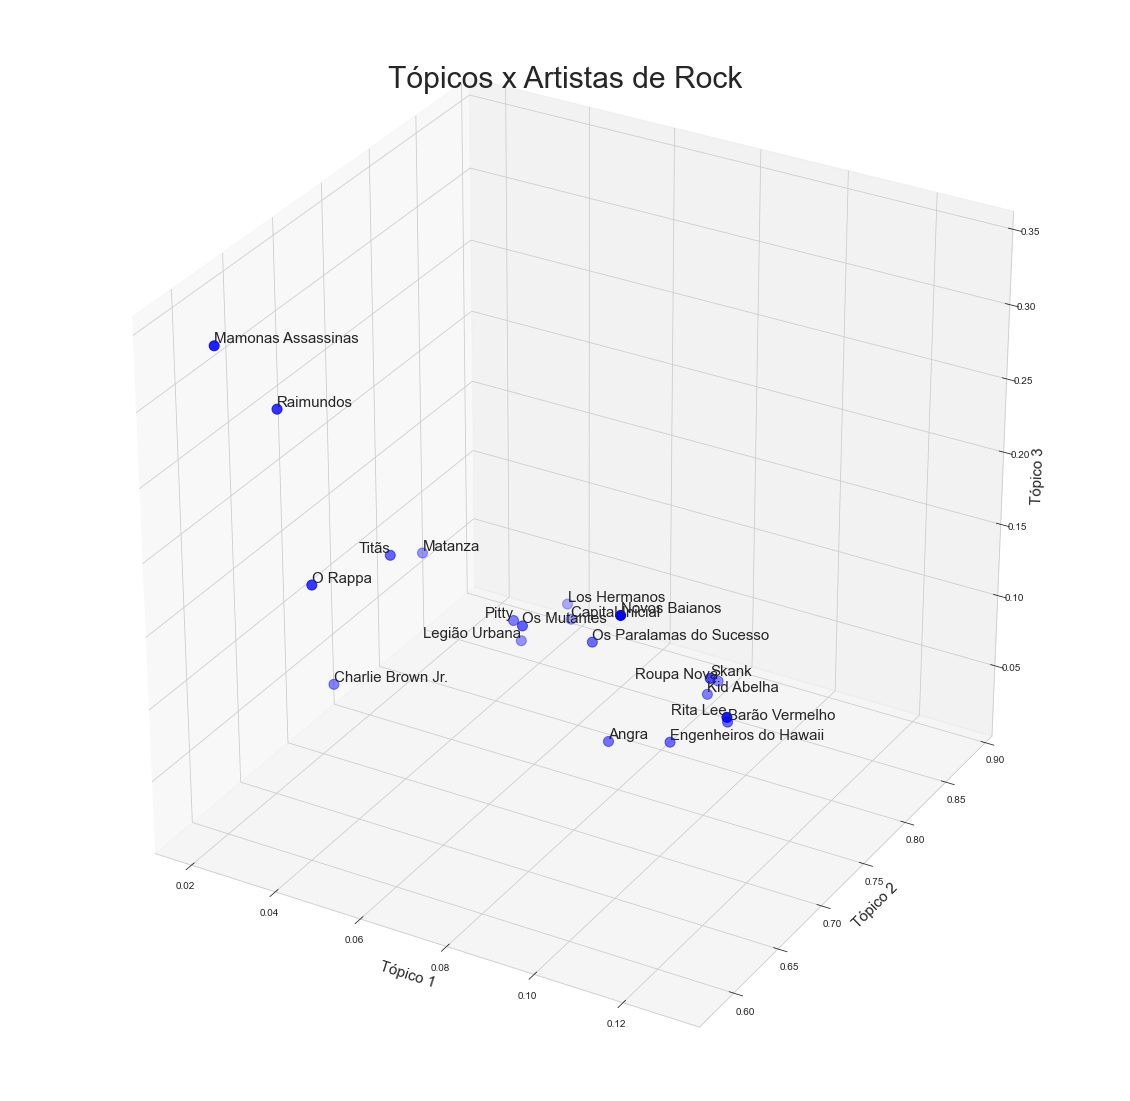

In [423]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

xs = centroids_topics_artists['Topic1']
ys = centroids_topics_artists['Topic2']
zs = centroids_topics_artists['Topic3']
label = centroids_topics_artists['group'].tolist()
ax.scatter(xs, ys, zs, color='blue', s=100)
for x,y,z, group in zip(xs,ys,zs,label):
    ax.text(x, y, z, '%s' % (group), size=15,  horizontalalignment=positions[group],verticalalignment='bottom')
      
ax.set_xlabel('Tópico 1', size = 15)
ax.set_ylabel('Tópico 2', size=15)
ax.set_zlabel('Tópico 3', size=15)
ax.set_title('Tópicos x Artistas de Rock', size=30)
plt.savefig(os.path.abspath(os.path.join('..', 'img','topics_lda_artists.jpg')))



### 3.6.2 SVD

In [337]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [338]:
tfidf = TfidfVectorizer(min_df=5)
tfidf_df = tfidf.fit_transform(text)

In [339]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_df)

In [340]:
tfidf_df = tfidf_df - tfidf_df.mean()

In [341]:
svd = TruncatedSVD(n_components = 3, n_iter = 100)
lsa = svd.fit_transform(tfidf_df)

In [342]:
topic_vectors = pd.DataFrame(data = lsa, columns = ['Topic1', 'Topic2', 'Topic3'])

In [343]:
topic_vectors.loc[:,['Topic1','Topic2','Topic3']] = topic_vectors.loc[:,['Topic1','Topic2','Topic3']].apply(np.abs)

In [344]:
topic_vectors['lyrics'] = lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt']

In [345]:
topic_vectors['group'] = lyrics_lang_normalized_tokenized['group']

In [346]:
centroids_artists = topic_vectors.groupby('group').apply(np.mean).reset_index()

In [347]:
sns.set_palette(sns.color_palette("cubehelix"))

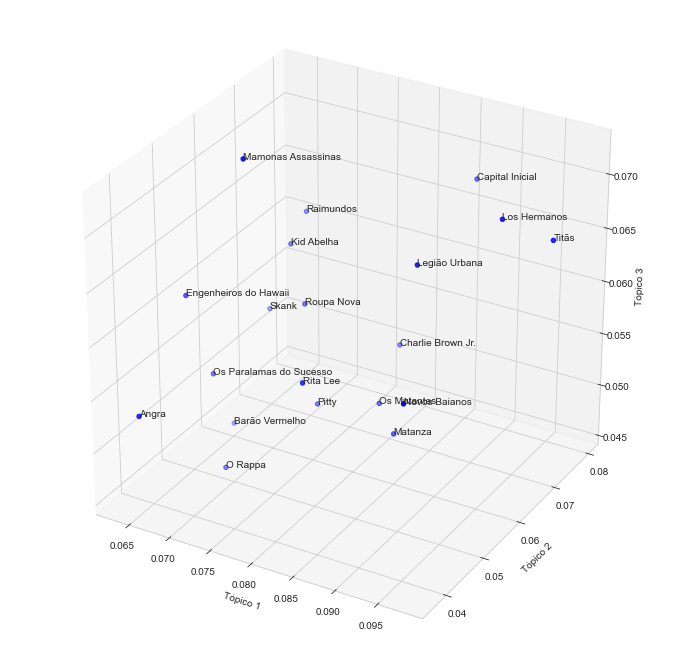

In [361]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

xs = centroids_artists['Topic1']
ys = centroids_artists['Topic2']
zs = centroids_artists['Topic3']
label = centroids_artists['group'].tolist()
ax.scatter(xs, ys, zs, color='b')
for x,y,z, group in zip(xs,ys,zs,label):
    ax.text(x, y, z, '%s' % (group), size=10)

ax.set_xlabel('Tópico 1')
ax.set_ylabel('Tópico 2')
ax.set_zlabel('Tópico 3')
plt.savefig(os.path.abspath(os.path.join('..', 'img','topics_lsa_artists.jpg')))

In [362]:
column_nums, terms = zip(*sorted(zip(tfidf.vocabulary_.values(),tfidf.vocabulary_.keys())))

In [363]:
topics_words = pd.DataFrame(svd.components_, columns = terms)